# Particle Swarm Neural Network Tutorial

This is a tutorial to implement a feedforward neural network using particle swarm optimization (PSO) to train the network. The "go-to" approach for training a neural network is typically backpropagation, but there is merit to experimenting with metaheuristics to optimize neural network weights.

I've previously written a tutorial on both neural networks (using backpropagation) and particle swarm optimization and want to combine both into one to show how PSO can be used to train a neural network in lieu of backpropgation.

This tutorial does presuppose you've read both the linked tutorials above, so I won't be going into as much detail on how neural networks or PSO work alone. While I start my PSO-trained network from scratch, I don't restate things that I've said previously. Feel free to distribute, edit, make changes, improve, etc this tutorial. If you publish it elsewhere, please let me know and link back.

## Neural Networks

Without a complete retread of my neural network tutorial, you should know that for the purpose of this tutorial, our neural network is simply a series of weights between neurons. Unlike with backpropagation training, where the network stored neural error deltas and outputs alongside their weights, we only really care about the weights. However, the neural network doesn't optimize the synapse weights, rather we rely on the metaheuristic instead for this purpose.

## Particle Swarms

For our neural network, we'll be using PSO to train the network. How? To perform PSO on some optimization problem, we need to know the fitness function as well as the search space. For our neural network, the possibilities of synapse weight combinations is our search space and our error or loss function is our fitness function. We'll be using the mean squared error as our error function. Over time, PSO will find an optimized set of weights which we then initialize our network as.

While we know what we're searching for within our search space, we don't necessarily know the bounds of the search space. We'll make an informed guess that our neural network weights will be fairly small and similar in magnitude so we can still perform PSO even without knowing the search space bounds.

Like vanilla PSO, we know our search space (loosely) and our fitness function, so we can generate a swarm of candidate solutions to our optimization problem and then "evolve" them over time. Over time, solutions within our swarm will congregate around the global optima for our loss function.

## Pseudocode

Pseudocode for the algorithm is as below:

```
procedure pso-nn() is:
  initialize network structure
  initialize random swarm s of particles
  for each epoch do:
    for each particle p in swarm s do:
      for each dimension d in search space do:
        new_vel, new_pos = [], []
        new_vel[d] := w * p.vel
        new_vel[d] += c1 * r1 * (p.best_pos[d] - p.pos[d])
        new_vel[d] += c2 * r2 * (s.best_pos[d] - p.pos[d])
        new_pos[d] := p.pos[d] + new_vel[d]
      endfor
      p.vel = new_vel
      p.pos = new_pos
    endfor
    for each particle p in swarm s do:
      if fitness(p.pos) < p.fit do:
        p.fit := fitness(p.pos)
      endif
    endfor
    update swarm best
    update particle bests
  endfor
  network weights := best from s
endprocedure
```

Note this is identical to the pseudocode for the PSO algorithm as found in that tutorial, with the only addition being the best in swarm serves as weight initialization for the network.

## Before you Begin

This tutorial uses Python and two non-standard dependencies:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc)
- X11 or equivalent
- `matplotlib`
- `pandas`
- some data

We'll be using `matplotlib` to graph the mean squared error and model accuracy over time but otherwise doesn't need this library. I use it for illustrative purposes but you can omit it if you don't wish to verify the system works. `pandas` is used for a very important step: normalizing the data. The algorithm will work without it but at a detriment.

As for the data, I will be using the Wine data set (see `/data`) but the implementation will be data agnostic. Since the network's input and output layer structures are dependent on the data, it will be generalized to take any data set and adjust the model as necessary.

## Loading the Data

Before implementing the network and metaheuristic, we need to handle how data is loaded and stored.

The Wine data set consists of 178 examples of 13-dimensional data (thirteen continuous features per row) along with a discrete classification (three classes). We'll split the data into training and testing sets with a 70%/30% ratio. This means the network is trained on 70% of the data and tested upon the remaining 30%.

For our PSO algorithm to work, we need to know the search space. While we know the search space is the set of possible weight permutations, we don't yet know the boundaries of the search space. In fact, there's no declarative way to determine the space boundaries but we can make an informed guess that the weights will be relatively small and of similar magnitudes. We'll normalize our input data around 0 to shrink the total search space and make an assumption the weights will be within `[-7.00, 7.00]`.

Here we'll load the data, normalize it, and then split it into our training and testing portions:

In [1]:
import pandas as pd

def load_data(filename):
    """Loads CSV for splitting into training and testing data.
    
    Parameters:
        filename : the filename of the file to load.
    
    Returns:
        Two lists, each corresponding to training and testing data.
    """
    # load into pandas dataframe
    df = pd.read_csv(filename, header=None, dtype=float)
    # normalize the data
    for features in range(len(df.columns)-1):
        df[features] = (df[features] - df[features].mean())/df[features].std()
    train = df.sample(frac=0.70).fillna(0.00) # get training portion
    test = df.drop(train.index).fillna(0.00) # remainder testing portion
    return train.values.tolist(), test.values.tolist()

Using the above function, we load the CSV into a master dataframe, normalize the features, then take a random 70% sample as training data and use the remaining as testing data. We'll output the number of examples for each to verify as well as find the number of columns in the data (attributes) and the number of unique classifications in the data (classes):

In [2]:
# get training/testing data
TRAIN, TEST = load_data('./data/wine.csv')

print(f'Training examples: {len(TRAIN)}')
print(f'Testing examples: {len(TEST)}')

# count number of attributes
FEATURES = len(TRAIN[0][:-1])
# count number of unique classifications
CLASSES = len(list(set([c[-1] for c in (TRAIN+TEST)])))

print(f'\nFeatures: {FEATURES}, Classes: {CLASSES}')

Training examples: 125
Testing examples: 53

Features: 13, Classes: 3


This is congruent with what we know about the data set in terms of features and classes. We'll use these counts when initializing the network shortly as we want the input layer size to match the number of attributes and the output layer to match the number of unique classifications. The input and output layers are a consequence of the data and not user defined.

## Initializing the Network

Since we know the size of the input and output layers, we need only come up with a hidden layer size to begin network initialization. We'll use six hidden neurons in our lone hidden layer giving us a `13-6-3` network structure.

Later on we'll need a way to encode a particle to use as weights for the network, so our network initializer will take this into consideration. We're still using bias for our network, so each of our particles will need to be `h * (n+1) + o * (h+1)` long, where `n` is the size of our input layer, `h` our hidden layer, and `o` our output layer. For our `13-6-3` network, this means our particles will be in `105` dimensions.

Here is our network initializer:

In [3]:
HIDDEN_SIZE = 6

def initialize_network(p):
    """Neural network initializer.
    
    Parameters:
        p : the particle to encode into the network.
    
    Returns:
        The n-h-o neural network.
    """
    n, h, o = FEATURES, HIDDEN_SIZE, CLASSES
    part = iter(p) # make iterator from p
    neural_network = [] # initially an empty list
    # there are (n * h) connections between input layer and hidden layer
    neural_network.append([[next(part) for i in range(n+1)] for j in range(h)])
    # there are (h * o) connections between hidden layer and output layer
    neural_network.append([[next(part) for i in range(h+1)] for j in range(o)])
    return neural_network

Like how a network should be initialized with weights within a small interval such as `[-1.00, 1.00]` or `[0.00, 1.00]`, we want to also initialize our particles in `n`-space at random with each axis being within a similarly small interval. Right now we'll make a sample particle and output the network structure to verify it was initialized correctly:

In [4]:
import random

DIMENSIONS = (HIDDEN_SIZE * (FEATURES+1)) + \
    (CLASSES * (HIDDEN_SIZE+1))

SAMPLE_PARTICLE = [round(random.uniform(-1.00, 1.00),2) \
    for _ in range(DIMENSIONS)]

NETWORK = initialize_network(SAMPLE_PARTICLE)

for layer in NETWORK:
    for neuron in layer:
        print(neuron)
    print('\n')

[ 0.68,  0.15,  0.60,  0.60,  0.18,  0.91, -0.50,  0.32,  0.79, -0.67,  0.04, -0.08,  0.19, -0.19]
[ 0.49, -0.19, -0.63, -0.66,  0.31,  0.17, -0.56,  0.89,  0.18, -0.13, -0.93, -0.20,  0.25,  0.38]
[ 0.13, -0.79, -0.35,  0.86, -0.04,  0.18, -0.51, -0.29,  0.58, -0.69, -0.97, -0.84,  0.81,  0.39]
[-0.56,  0.51,  0.16, -0.07,  0.29,  0.79,  0.15, -0.77, -0.29,  0.73,  0.81, -0.56, -0.67,  0.37]
[-0.95,  0.12, -0.79, -0.76, -0.02,  0.35, -0.90, -0.81,  0.04,  0.53, -0.02,  0.64, -0.53,  0.91]
[ 0.36,  0.52, -0.98,  0.45, -0.65,  0.85,  0.19, -0.01,  0.27,  0.78, -0.63,  0.14,  0.95, -0.18]

[-0.01,  0.30,  0.89, -0.01,  0.11, -0.27, -0.16]
[ 0.32, -0.38,  0.65, -0.90, -0.67,  0.27,  0.45]
[-0.60,  0.98,  0.35,  0.48, -0.29, -0.95,  0.60]


It's been truncated for readability; when we begin making particles, we don't want to trim off excess decimal places.

What you should take from this output is there are two layers of connections (between the input and hidden layers, and between the hidden and output layers). For the first set of weights, there is a set for each of the neurons in the hidden layer (`6`), each consisting of `14` weights (`13` from input layer + `1` bias). For the second set of weights, there is a set for each of the neurons in the output layer (`3`), each of `7` weights (`6` from hidden layer + `1` bias).

This is congruent with our expected structure, however seeing the structure is not terribly important right now.

## Fitness Function

So far, we have a way to encode the candidate solution into a network but not a way to test how well the network performs. We've established our fitness function will be the mean squared error function, and to this end, we need to implement some of the busywork involved with any feedforward neural network.

We'll need to feed data forward into the network (it is a feedforward network after all) to calculate the mean squared error, so much of the below is just an implementation of those requirements.

### Summing and Activation Functions

The summing function takes neural inputs and aggregates them to be sent to the next layer. In our network, for example, one of the hidden neurons takes eight inputs and needs to create one output from it. To this end, we use a summing function to concatenate them by using the weighted sum of the neural inputs. Each input will contribute a different amount to the output and we use the synapse weights to determine this.

In [5]:
def summing_function(weights, inputs):
    """Sums the synapse weights with inputs and bias.
    
    Parameters:
        weights : synaptic weights.
        inputs : a vector of inputs.
    
    Returns:
        The aggregate of inputs times weights, plus bias.
    """
    # bias is the final value in the weight vector
    bias = weights[-1]
    summ = 0.00 # to sum
    for i in range(len(weights)-1):
        # aggregate the weights with input values
        summ += (weights[i] * float(inputs[i]))
    return summ + bias

Once we have the weighted sum of the neural inputs, this sum is transferred to an activation function. This function determines the neuron activation or firing: for linear activations, this is a binary "ON" or "OFF", whereas with non-linear activations, it's a degree of "ON".

We'll use the rectified linear unit activation function:

$$\text{ReLU}(z) = \left\{ \begin{array}{ll} z & \text{if }z \geq 0 \\ 0 & \text{if }z \lt 0 \end{array} \right.$$

We can implement this like so:

In [6]:
def activation_function(z):
    """ReLU activation function.
    
    Parameters:
        z : summed output of neuron.
    
    Returns:
        The neuron activation based on the summed output.
    """
    return z if z >= 0 else 0

I've chosen ReLU because some of the problems inherent with ReLU, such as vanishing gradient or dead neurons are a non-issue when we're not using the activation derivative. ReLU is a great activation function when these issues are non-existent, which makes it the perfect candidate for our activation function.

We can plot this function to see what it looks like:

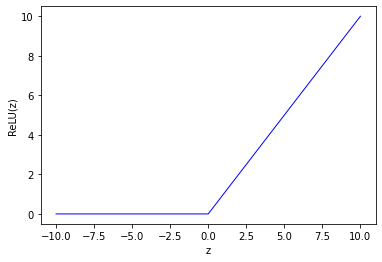

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

x = range(-10, 10+1, 1)
y = [activation_function(z) for z in x]
plt.plot(x, y, c='blue', lw='1')
plt.ylabel('ReLU(z)')
plt.xlabel('z')
plt.show()
plt.clf()

Note it's a combination of linear ($f(x) = x$) and constant ($f(x) = 0$) functions. A negative signal is clamped to zero but otherwise unperturbed.

Now we've determined how a neuron will accept an input and produce an output. These two functions are all we need to implement our feedforward function.

### Feedforward Function

For our feedforward function, we only needed the summation and activation functions as previously defined. Data is fed into the network starting at the first layer, it is processed by the neurons in the input layer, neural outputs are calculated as a function of the data, the neuron's weighted sum of the data, and this value transferred to the activation function. Then, the next layer takes those outputs as inputs and the process cycles until you reach the output layer.

Since we don't need to store outputs within the neurons (as would be the case for backpropagation), the feedforward function need only return a value and not mutate the network in any way.

In [8]:
def feed_forward(network, example):
    """Feedforward method. Feeds data forward through network.
    
    Parameters:
        network : the neural network.
        example : an example of data to feed forward.
    
    Returns:
        The output of the forward pass.
    """
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            # sum the weight with inputs
            summ = summing_function(neuron, layer_input)
            # activate the sum, append output to outputs
            layer_output.append(activation_function(summ))
        # inputs become outputs of previous layer
        layer_input, layer_output = layer_output, []
    return layer_input # return the final output

We've done all of this because our error function demands the use of data being fed into the network to calculate the network error.

### Mean Squared Error

Now that we can feedforward data through the network, we can implement our error function, the mean squared error. The mean squared error function will feed all training data into the network and find the average error between them. The error is calculated as a function of what is known about the data (the classification is already known) versus what the network outputs.

In [9]:
def sse(actual, target):
    """Sum of Squared Error.
    
    Parameters:
        actual : network output.
        target : example target output.
    
    Returns:
        The sum of squared error of the network for an example.
    """
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def mse(network):
    """Mean Squared Error.
    
    Parameters:
        network : the neural network to test.
    """
    training = TRAIN
    summ = 0.00
    # for each training example
    for example in training:
        # populate a target vector
        target = [0 for _ in range(CLASSES)]
        # denote correct classification
        target[int(example[-1])] = 1
        # get actual output by feeding example through network
        actual = feed_forward(network, example)
        # sum up the sum of squared error
        summ += sse(actual, target)
    # MSE is just sum(sse)/number of examples
    return summ / len(training)

Note that the mean squared error is simply the mean of the sum of squared error per training example. This gives us the network error considering every training example.

## The Particle Swarm Part

So far, we've only been fooling around with the neural network side of things when the brunt of this tutorial will instead focus upon the PSO side of things. At this point we have our fitness function and can begin to populate a swarm with particles.

As previously mentioned, we're using a PSO algorithm to train the network. This is a misnomer, as the use of a metaheuristic such as PSO instead tries to find weights and doesn't update weights as an informed decision. It is, however, an informed search. We look at a swarm of possible weights, see which works the best, and then update the swarm based on the swarm best. To compare, a random search wouldn't be informed whereas a PSO algorithm makes decisions which ensure we get a better fitness over time.

### Representing Particles

A particle for our algorithm is some encoding of network weights. Given a network, we need a way to represent it as a single array or list. Thankfully it is relatively straightforward: we take our network, take each weight in order, and represent it as a point in `n`-space, where `n` is the number of weights and biases. These points are our particles. For the Wine data set, our particles are in `105`-space.

First we'll make a class to containerize a particle:

In [10]:
class Particle:
    """Particle class.
    Containzerizes a position, velocity.
    
    Attributes:
        pos : the position in n-space.
        best_pos : the best position this particle has had.
        fit : the fitness of the particle.
        best_fit : the best fitness this particle has had.
        vel : the velocity in n-space.
    """
    
    def __init__(self, pos, vel):
        """Particle constructor."""
        # initialize position and velocity as params
        self.pos, self.vel = pos, vel
        # find fitness at instantiation
        network = initialize_network(self.pos)
        self.fit = mse(network)
        # best so far is just initial
        self.best_pos, self.best_fit = self.pos, self.fit
    
    def set_pos(self, pos):
        """Position mutator method."""
        self.pos = pos
        if not any(p < -7.00 for p in pos)\
        and not any(p > 7.00 for p in pos):
            # get fitness of new position
            network = initialize_network(self.pos)
            fitness = mse(network)
            # if better
            if fitness < self.best_fit:
                self.fit = fitness
                # update best fitness
                self.best_fit = self.fit
                # update best position
                self.best_pos = self.pos
    
    def set_vel(self, vel):
        """Velocity mutator method."""
        self.vel = vel
    
    def get_pos(self):
        """Position accessor method."""
        return self.pos
    
    def get_vel(self):
        """Velocity accessor method."""
        return self.vel
    
    def get_best_pos(self):
        """Best position accessor method."""
        return self.best_pos

    def get_fit(self):
        """Fitness accessor method."""
        return self.fit
    
    def get_best_fit(self):
        """Best fitness accessor method."""
        return self.best_fit
    
    def __lt__(self, other):
        return self.fit < other.fit

Since we now know how particles are represented, we can make a swarm of them.

### Swarm Initialization

First, we need to initialize an initial swarm. Since we don't know our search space bounds, we'll use an initialization strategy placing each particle within `[-1.00, 1.00]`, our swarm consists of particles in `105`-space where each axis is randomized within this interval. Recall a particle is just an encoding of some solution to the problem: our solutions are in `105` dimensions so particles are also in `105` dimensions. Additionally, we'll start with a swarm size of `100`:

In [11]:
import random

SWARM_SIZE = 100 # how large our swarm is

def initialize_swarm(size, dim):
    """Swarm initialization function.
    
    Parameters:
        size : the size of our swarm.
        dim : the dimensionality of the problem.
    
    Returns:
        A random swarm of that many Particles.
    """
    swarm = [] # swarm stored as list
    for _ in range(size): # for the size of the swarm
        # position is random in every dimension
        position = [random.uniform(-1.00, 1.00) for _ in range(dim)]
        # velocity is initially zero in every dimension
        velocity = [0 for _ in range(dim)]
        # init a particle
        particle = Particle(position, velocity)
        swarm.append(particle) # add to swarm
    return swarm

SWARM = initialize_swarm(SWARM_SIZE, DIMENSIONS)

We don't need to sort our population by fitness but we'll still make a function to do this and print the five best particle fitnesses to verify our algorithm works:

In [12]:
def print_five_best():
    SWARM.sort()
    for i in range(5):
        print(f'Particle {i+1} = {SWARM[i].get_fit()}')

print_five_best()

Particle 1 = 0.987354856821158
Particle 2 = 1.07611596069502
Particle 3 = 1.1569260312369962
Particle 4 = 1.2170419249411921
Particle 5 = 1.241404249558855


We'll use this function a couple more times to verify that solutions improve over time.

### Moving Particles

Particles move within the search space based on the PSO parameters: the inertial weight and social and cognitive coefficients. These should be empirically found for each problem and shouldn't be known a priori but there are a few shortcuts that can be used: some parameter choices have been empirically found to work well if not great for most problems.

Here we'll use some parameters I've found to work well for this specific network and data set:

In [13]:
W = 0.3 # intertial weight
C_1 = 1.5 # cognitive coefficient
C_2 = 1.2 # social coefficient

To actually move the particles, we need a way to find the swarm best position:

In [14]:
def get_swarm_best(swarm):
    """Finds the swarm best fitness and position.
    
    Parameters:
        swarm : the swarm to search.
        
    Returns:
        The swarm best fitness and swarm best position.
    """
    # initially assume the first is the best
    best_fit = swarm[0].get_fit()
    best_pos = swarm[0].get_pos()
    for particle in swarm: # for each particle
        # if better fitness found
        if particle.get_fit() < best_fit:
            # update best fitness and position
            best_fit = particle.get_fit()
            best_pos = particle.get_pos()
    return best_fit, best_pos

We'll use this function several times when we update our positions. And about updating the positions, it is simply a function of the swarm best position, each particle's best position, their current positions and velocities, and the PSO parameters as defined previously. The math is below:

$$p_i(t+1) = p_i(t) + v_i(t+1)$$

Or, for a dimension $i$, the new position in that dimension is a function of its prior position and new velocity. Here $(t+1)$ means the current iterative step and $t$ is the prior. The new velocity is calculated as:

$$v_i(t+1) = \omega v_i(t) + c_1r_1(y(t) - x_i(t)) + c_2r_2(\hat{y}(t) - x_i(t))$$

Where $\omega$ is the inertial weight, $c_1$ and $c_2$ are the cognitive and social coefficients respectively, $r_1$ and $r_2$ are stochastic multiplicands, and $y$ and $\hat{y}$ is the particle best position and swarm best position respectively. It's useful to think of it split into three separate terms: a weight term ($w$), a cognitive term ($c$) and a social term ($s$):

$$\begin{align}
w &= \omega v_i(t) \nonumber \\
c &= c_1r_1 (y(t) - x_i(t)) \nonumber \\
s &= c_2r_2 (\hat{y}(t) - x_i(t)) \nonumber 
\end{align}$$

Since each term in order deals with the inertial weight, cognitive aspect, and social aspect of the velocity update. The new velocity is simply:

$$v_i(t+1) = w + c + s$$

We'll implement particle movement below:

In [15]:
def move_particles(swarm, dim, ic, cc, sc):
    """Particle movement function.
    
    Parameters:
        swarm : the swarm to move.
        dim : dimensionality of the network.
        ic : inertial coefficient.
        cc : cognitive coefficient.
        sc : social coefficient.
    """
    # get swarm bests
    swarm_best = get_swarm_best(swarm)
    for particle in swarm: # for each particle
        # new position and velocity is initially zero
        new_pos = [0 for _ in range(dim)]
        new_vel = [0 for _ in range(dim)]
        for d in range(dim): # for each axis
            # the social and cognitive coefficients 
            # take a stochastic multiplicand
            r_1 = random.uniform(0.00, 1.00)
            r_2 = random.uniform(0.00, 1.00)
            # this is split for readability but the update is based
            # on an addition of a weight, cognitive, and social term
            weight = ic * particle.get_vel()[d]
            cognitive = cc * r_1
            cognitive *= (particle.get_best_pos()[d] - particle.get_pos()[d])
            social = sc * r_2
            social *= (swarm_best[1][d] - particle.get_pos()[d])
            # new velocity is simply weight + cognitive + social
            new_vel[d] = weight + cognitive + social
            # new position is just old position + velocity
            new_pos[d] = particle.get_pos()[d] + new_vel[d]
        # update particle with new position and velocity
        particle.set_pos(new_pos)
        particle.set_vel(new_vel)

We can then move the particles five times to see how the best fitness improves:

In [16]:
SWARM.sort()
print(f'Initial fitness: {SWARM[0].get_fit():.4f}')

for i in range(5):
    move_particles(SWARM, DIMENSIONS, W, C_1, C_2)
    best = get_swarm_best(SWARM)
    print(f'Iteration {i+1} fitness: {best[0]:.4f}')

Initial fitness: 0.9874
Iteration 1 fitness: 0.6415
Iteration 2 fitness: 0.6178
Iteration 3 fitness: 0.5488
Iteration 4 fitness: 0.5227
Iteration 5 fitness: 0.4667


Here the fitness was initially around `0.99` and moving the particles five times made the most fit particle move around such that the best fitness is now roughly `0.47`, our anticipated behavior.

## Measuring Performance

The goal to using PSO to train our network is to optimize the weights such that the mean squared error function is minimized. We know classification accuracy is (roughly) inversely proportional to the mean squared error but we should examine this as well. We'll use the below functions to make a nice graph later:

In [17]:
def performance_measure(particle, data):
    """Measures accuracy of the network using classification error.

    Parameters:
        particle : the particle to test.
        data : a set of data examples.
    Returns:
        A percentage of correct classifications.
    """
    network = initialize_network(particle)
    correct, total = 0, 0
    for example in data:
        # check to see if the network output matches target output
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return 100*(correct / total)

def check_output(network, example):
    """Compares network output to actual output.

    Parameters:
        network : the neural network.
        example : an example of data.
    Returns:
        The class the example belongs to (based on network guess).
    """
    output = feed_forward(network, example)
    return output.index(max(output))

This is just another way for us to look at the network performance. We could even use the classification accuracy as our PSO algorithm fitness function but it is safer to use the mean squared error for this reason instead.

## Main Driver

In essence, we've finished our PSO algorithm for training a network but we should make a main driver to move particles over several iterations:

In [18]:
EPOCHS = 100

MSE = [] # to store MSE over epochs
TRP = [] # training accuracy over epochs
TEP = [] # testing accuracy over epochs

def pso(dim, epochs, swarm_size, ic, cc, sc):
    """Particle Network training function
    Main driver for PSO algorithm

    Parameters:
        dim : dimensionality of the problem.
        epochs : how many iterations.
        swarm_size : how big a swarm is.
        ic : inertial coefficient (omega).
        cc : cognitive coefficient (c_1).
        sc : social coefficient (c_2).
    
    Returns:
        Idealized network weights.
    """
    swarm = initialize_swarm(swarm_size, dim) # init swarm
    for e in range(1, epochs+1):
        # get swarm best fitness and position
        swarm_best = get_swarm_best(swarm)
        MSE.append(swarm_best[0]) # get error of network using swarm best
        # get classification error of network for training and test
        TRP.append(performance_measure(swarm_best[1], TRAIN))
        TEP.append(performance_measure(swarm_best[1], TEST))
        # reposition particles based on PSO params
        move_particles(swarm, dim, ic, cc, sc)
    return get_swarm_best(swarm)[0]

NETWORK = pso(DIMENSIONS, EPOCHS, SWARM_SIZE, W, C_1, C_2)

We have three global lists, MSE, TRP, and TEP to store the mean squared error, training performance, and testing performance per epoch of the algorithm. We can plot these:

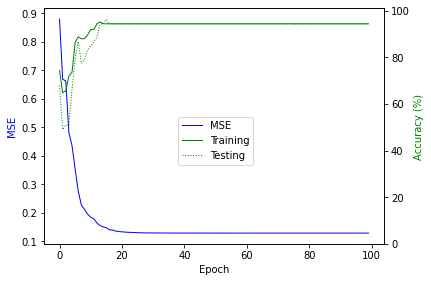

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_data():
    x = range(0, EPOCHS)
    fig, ax2 = plt.subplots()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE', color='blue')
    line, = ax2.plot(x, MSE, '-', c='blue', lw='1', label='MSE')
    ax1 = ax2.twinx()
    ax1.set_ylabel('Accuracy (%)', color='green')
    line2, = ax1.plot(x, TRP, '-', c='green', lw='1', label='Training')
    line3, = ax1.plot(x, TEP, ':', c='green', lw='1', label='Testing')
    fig.tight_layout()
    fig.legend(loc='center')
    ax1.set_ylim(0, 101)
    plt.show()
    plt.clf()
    
plot_data()

You can see over time the mean squared error is diminished, just as it would were you using backpropagation; as the mean squared error is inversely proportional to the accuracy of the network, you also see accuracy rise.

## Final Thoughts

It's interesting to think about a metaheuristic like particle swarm optimization algorithms in training a network. A lot of literature and even what you may have learned in school were you to take a computer science degree use PSO in different ways. At least for me, using one to train a neural network isn't standard curriculum but it still has merit to its study.

Using this method to train a neural network, we can achieve mostly comparable results. What I didn't mention in this tutorial is how slow it can be compared to backpropagation. However, depending on parameter choices, it tends to converge faster but not necessarily to the same found optimum. It would be useful to define some termination condition (for example, terminate if MSE is below a certain threshold) as often you do not need to run for many epochs but this is problem specific.

Further consideration should be given to the activation function used. ReLU has many pitfalls in backpropagation trained networks but performs great in metaheuristic trained networks. I chose it specifically because this is one scenario where there are few drawbacks to doing so. You should still look into other types of activation functions as well as experiment with differing PSO parameters to potential get better results.

The difficulty in using a metaheuristic like PSO is that the search space isn't known a priori. We can make some educated assumptions that idealized network weights are relatively small in magnitude and base some of our conditions around that: for example, initializing small and not updating fitness of a particle if it goes too far from the origin. PSO cares a little less about search boundaries than genetic algorithms but it's still an important thing to consider. This is why I've also normalized the data: doing this means weights remain closer to the origin, thus less orphan cases to catch were network weights large in comparison.

## Finished Code

Here is the full uncommented code:

In [ ]:
#!/usr/bin/env python3

import pandas as pd
import random
import matplotlib.pyplot as plt

class Particle:
    def __init__(self, pos, vel):
        self.pos, self.vel = pos, vel
        network = initialize_network(self.pos)
        self.fit = mse(network)
        self.best_pos, self.best_fit = self.pos, self.fit

    def set_pos(self, pos):
        self.pos = pos
        if not any(p < -7.00 for p in pos)\
        and not any(p > 7.00 for p in pos):
            network = initialize_network(self.pos)
            fitness = mse(network)
            if fitness < self.best_fit:
                self.fit = fitness
                self.best_fit = self.fit
                self.best_pos = self.pos

    def set_vel(self, vel):
        self.vel = vel

    def get_pos(self):
        return self.pos

    def get_vel(self):
        return self.vel

    def get_best_pos(self):
        return self.best_pos

    def get_fit(self):
        return self.fit

def pso(dim, epochs, swarm_size, ic, cc, sc):
    swarm = initialize_swarm(swarm_size, dim)
    for e in range(1, epochs+1):
        swarm_best = get_swarm_best(swarm)
        MSE.append(swarm_best[0])
        TRP.append(performance_measure(swarm_best[1], TRAIN))
        TEP.append(performance_measure(swarm_best[1], TEST))
        move_particles(swarm, dim, ic, cc, sc)
    return get_swarm_best(swarm)[0]

def move_particles(swarm, dim, ic, cc, sc):
    swarm_best = get_swarm_best(swarm)
    for particle in swarm:
        new_pos = [0 for _ in range(dim)]
        new_vel = [0 for _ in range(dim)]
        for d in range(dim):
            r_1 = random.uniform(0.00, 1.00)
            r_2 = random.uniform(0.00, 1.00)
            weight = ic * particle.get_vel()[d]
            cognitive = cc * r_1
            cognitive *= (particle.get_best_pos()[d] - particle.get_pos()[d])
            social = sc * r_2
            social *= (swarm_best[1][d] - particle.get_pos()[d])
            new_vel[d] = weight + cognitive + social
            new_pos[d] = particle.get_pos()[d] + new_vel[d]
        particle.set_pos(new_pos)
        particle.set_vel(new_vel)

def feed_forward(network, example):
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            summ = summing_function(neuron, layer_input)
            layer_output.append(activation_function(summ))
        layer_input, layer_output = layer_output, []
    return layer_input

def summing_function(weights, inputs):
    bias = weights[-1]
    summ = 0.00
    for i in range(len(weights)-1):
        summ += (weights[i] * float(inputs[i]))
    return summ + bias

def activation_function(z):
    return z if z >= 0 else 0

def sse(actual, target):
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def mse(network):
    training = TRAIN
    summ = 0.00
    for example in training:
        target = [0 for _ in range(CLASSES)]
        target[int(example[-1])] = 1
        actual = feed_forward(network, example)
        summ += sse(actual, target)
    return summ / len(training)

def performance_measure(particle, data):
    network = initialize_network(particle)
    correct, total = 0, 0
    for example in data:
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return 100*(correct / total)

def check_output(network, example):
    output = feed_forward(network, example)
    return output.index(max(output))

def initialize_network(p):
    n, h, o = FEATURES, HIDDEN_SIZE, CLASSES
    part = iter(p)
    neural_network = []
    neural_network.append([[next(part) for i in range(n+1)] for j in range(h)])
    neural_network.append([[next(part) for i in range(h+1)] for j in range(o)])
    return neural_network

def initialize_swarm(size, dim):
    swarm = []
    for _ in range(size):
        position = [random.uniform(-1.00, 1.00) for _ in range(dim)]
        velocity = [0 for _ in range(dim)]
        particle = Particle(position, velocity)
        swarm.append(particle)
    return swarm

def get_swarm_best(swarm):
    best_fit = swarm[0].get_fit()
    best_pos = swarm[0].get_pos()
    for particle in swarm:
        if particle.get_fit() < best_fit:
            best_fit = particle.get_fit()
            best_pos = particle.get_pos()
    return best_fit, best_pos

def load_data(filename):
    df = pd.read_csv(filename, header=None, dtype=float)
    for features in range(len(df.columns)-1):
        df[features] = (df[features] - df[features].mean())/df[features].std()
    train = df.sample(frac=0.70).fillna(0.00)
    test = df.drop(train.index).fillna(0.00)
    return train.values.tolist(), test.values.tolist()

def plot_data():
    x = range(0, EPOCHS)
    fig, ax2 = plt.subplots()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE', color='blue')
    line, = ax2.plot(x, MSE, '-', c='blue', lw='1', label='MSE')
    ax1 = ax2.twinx()
    ax1.set_ylabel('Accuracy (%)', color='green')
    line2, = ax1.plot(x, TRP, '-', c='green', lw='1', label='Training')
    line3, = ax1.plot(x, TEP, ':', c='green', lw='1', label='Testing')
    fig.tight_layout()
    fig.legend(loc='center')
    ax1.set_ylim(0, 101)
    plt.show()
    plt.clf()

if __name__ == '__main__':
    MSE = []
    TRP = []
    TEP = []
    W = 0.3
    C_1 = 1.5
    C_2 = 1.2
    TRAIN, TEST = load_data('../data/wine.csv')
    FEATURES = len(TRAIN[0][:-1])
    CLASSES = len(list(set([c[-1] for c in (TRAIN+TEST)])))
    HIDDEN_SIZE = 5
    DIMENSIONS = (HIDDEN_SIZE * (FEATURES+1)) + \
        (CLASSES * (HIDDEN_SIZE+1))
    SWARM_SIZE = 100
    EPOCHS = 100
    NETWORK = pso(DIMENSIONS, EPOCHS, SWARM_SIZE, W, C_1, C_2)
    plot_data()

You may wish to catch for errors (as I have done none here), and perhaps accept some of the parameters as command line arguments. This code, as-is, should run in a terminal but allows for zero customization unless you change the code manually. Some parameters might include hidden layer size, PSO coefficients, how many epochs, etc. This is just a basic implementation to springboard off of and experiment with.

You can save this code as `particle_network.py` and execute it as one of the below:

```
$ python3 particle_network.py
$ ./particle_network.py
```

You can also find the code along with a commented version in `./code`.